In [1]:
from graph_ds import PyH3Graph
from pois_to_h3 import get_pois_h3
from ghsl_processing import get_origins, city_boundaries_to_h3 

import pandas as pd
import h3.api.numpy_int as h3
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import seaborn as sns
import pickle


def plot_hex_df(df, markersize, color_column=None, color_categorical=False):
    df[['y','x']] = list(df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    fig, ax = plt.subplots(figsize=(10,10))
    # Show the GeoPandas DataFrame

    if color_column:
        gdf.plot(ax=ax, column=color_column, categorical=color_categorical,
                  legend=True, markersize=markersize, alpha=0.5, cmap='Reds',
                  vmin=0, vmax=25)
    else:
        gdf.plot(ax=ax, markersize=markersize, alpha=0.5)

    #plt.xlim(12.391681,12.737388)
    #plt.ylim(55.549206, 55.759991)

    cx.add_basemap(ax = ax, crs="EPSG:4326")
    #plt.show()

def routing(category_set, origins, destinations, num_origins, graph):
    # get residential origins, sample with replacement
    origins = list(origins[origins['residential_bool']==1].sample(num_origins, replace=True)['h3_index'])

    mins={}
    category_travel_time_means = {}
    for c in category_set:
        cat_destinations = list(destinations[destinations['category']==c]['h3_index'])
        ds = graph.matrix_distance(origins=origins, destinations=cat_destinations, dynamic_infinity=True)

        # they might be different lengths, so we can't use a df
        mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
        category_travel_time_means[c] = np.nanmean(list(mins[c].values()))

    return category_travel_time_means, mins


/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Instructions
- necessary downloads:
    - pbf file for pois, crop with https://extract.bbbike.org if cities are not available for direct download
        - run pbf file through osmium to get points on ways
    - .tif raster ghsl data for building types at https://ghsl.jrc.ec.europa.eu/ghs_buC2022.php
    - Download gtfs public transport data (all files, if there are many) for the city in question
        - Many possible sources...

- finally: enjoy :)

In [2]:
# get bbox for all of these cities so that I can extract bbbike data
code_mappings: dict = {
    '846': 'Mariagerfjord Kommune',
    '741': 'Samsø Kommune',
    '760': 'Ringkøbing-Skjern Kommune',
    '710': 'Favrskov Kommune',
    '480': 'Nordfyns Kommune',
    '492': 'Ærø Kommune',
    '270': 'Gribskov Kommune',
    '730': 'Randers Kommune',
    '450': 'Nyborg Kommune',
    '169': 'Høje-Taastrup Kommune',
    '621': 'Kolding Kommune',
    '250': 'Frederikssund Kommune',
    '147': 'Frederiksberg Kommune',
    '230': 'Rudersdal Kommune',
    '155': 'Dragør Kommune',
    '101': 'København Kommune',
    '147': 'Frederiksberg Kommune',
    '825': 'Læsø Kommune',
    '550': 'Tønder Kommune',
    '665': 'Lemvig Kommune',
    '760': 'Ringkøbing-Skjern Kommune',
}

In [3]:
# Inputs
# municipality names
# municipailties are lists because you can add many into one analysis
municipalities = [[x] for x in code_mappings.values()]
# public transport
gtfs_paths = ["../resources/rejseplanen_GTFS.zip"]*len(municipalities)
# ghsl data for building types
#tif_paths = ['../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif', '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif']
tif_paths = ['../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif']*len(municipalities)

In [4]:
# Parameters

# 12 is around 10 meter resolution
H3_RES = 12

# how many origins to sample
num_origins = 1000

#essential filter will be the least restrictive
essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors","school"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park"], "sport":True
    }

# categories considered for the n-minute calculation
category_set = ['pharmacy','park','supermarket','sport', 'school']

# how to map osm tags to categories
osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport'
}

In [5]:
# osm file processing
osm_names = ['_'.join(x)+'_processed.osm.pbf' for x in municipalities]
relative_path_osm = "../resources/osm/"
osm_paths = [relative_path_osm + x for x in osm_names]

In [6]:
# pipeline
results={}
for i,municipality in enumerate(municipalities):

    # which cities do we want?, make sure your PBF file contains these cities!!!
    # use the bounding box returned here to make your pbf crop on extract.bbbikes.org
    print(f"getting boundaries for {municipality}")
    city_bounds_h3, bbox, bbox_pois = city_boundaries_to_h3(municipality)
    
    # get origins (save for later)
    print(f"getting origins for {municipality}")
    origins = get_origins(H3_RES, municipality, bbox, tif_paths[i], city_bounds_h3)

    # get destinations (save for later)
    print(f"getting destinations for {municipality}")
    destinations = get_pois_h3(osm_paths[i], essential_filter, H3_RES, category_set, osm_tag_mapping, municipality)

    key = "_".join(municipality)
    results[key]={}
    print(f"Routing for {municipality}:")
    for g in ['all', 'walk', 'walk+bike', 'walk+transit']:
        print(g)
        # build the graph
        graph = PyH3Graph(bike_penalty=1, k_ring=2, layers=g)
        graph.create(osm_path=osm_paths[i],gtfs_path=gtfs_paths[i])
        # do routing
        category_means, route_mins = routing(category_set, origins, destinations, num_origins, graph)
        # save results as dictionary
        results[key].update({g:route_mins})

getting boundaries for ['Mariagerfjord Kommune']
getting origins for ['Mariagerfjord Kommune']
getting destinations for ['Mariagerfjord Kommune']


/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Mariagerfjord Kommune']:
all
processing osm pbf file: ../resources/osm/Mariagerfjord Kommune_processed.osm.pbf
converted OSM file into 514231 edges
osm graph created with (494750) nodes (walk + bike) in 23 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 31 s
merged graph created with 598876 nodes in 0 s
hash: 8800012202148072322
matrix distance computed for 835 origins - got 834 results
matrix distance computed for 835 origins - got 834 results
matrix distance computed for 835 origins - got 834 results
matrix distance computed for 835 origins - got 834 results
matrix distance computed for 835 origins - got 834 results
walk
processing osm pbf file: ../resources/osm/Mariagerfjord Kommune_processed.osm.pbf
converted OSM file into 501024 edges
osm graph created with (481480) nodes (walk + bike) in 21 s
hash: 5384862467966652023
matrix distance computed for 829 origins - got 828 results
matrix distance computed fo

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 829 origins - got 828 results
matrix distance computed for 829 origins - got 828 results
matrix distance computed for 829 origins - got 828 results
walk+bike
processing osm pbf file: ../resources/osm/Mariagerfjord Kommune_processed.osm.pbf
converted OSM file into 514231 edges
osm graph created with (494750) nodes (walk + bike) in 22 s
hash: 13145988741000893732
matrix distance computed for 845 origins - got 844 results
matrix distance computed for 845 origins - got 844 results
matrix distance computed for 845 origins - got 844 results
matrix distance computed for 845 origins - got 844 results
matrix distance computed for 845 origins - got 844 results
walk+transit
processing osm pbf file: ../resources/osm/Mariagerfjord Kommune_processed.osm.pbf
converted OSM file into 501024 edges
osm graph created with (481480) nodes (walk + bike) in 21 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 31 s
merge

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


Routing for ['Samsø Kommune']:
all
processing osm pbf file: ../resources/osm/Samsø Kommune_processed.osm.pbf
converted OSM file into 40527 edges
osm graph created with (38490) nodes (walk + bike) in 2 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 31 s
merged graph created with 143371 nodes in 0 s
hash: 333109885270788549
matrix distance computed for 818 origins - got 817 results
matrix distance computed for 818 origins - got 817 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:48: RuntimeWarning: Mean of empty slice
  category_travel_time_means[c] = np.nanmean(list(mins[c].values()))


matrix distance computed for 818 origins - got 817 results
matrix distance computed for 818 origins - got 817 results
matrix distance computed for 818 origins - got 817 results
walk
processing osm pbf file: ../resources/osm/Samsø Kommune_processed.osm.pbf
converted OSM file into 38399 edges
osm graph created with (36343) nodes (walk + bike) in 2 s
hash: 13548306004349588766
matrix distance computed for 805 origins - got 804 results
matrix distance computed for 805 origins - got 804 results
matrix distance computed for 805 origins - got 804 results
matrix distance computed for 805 origins - got 804 results
matrix distance computed for 805 origins - got 804 results
walk+bike
processing osm pbf file: ../resources/osm/Samsø Kommune_processed.osm.pbf
converted OSM file into 40527 edges
osm graph created with (38490) nodes (walk + bike) in 2 s
hash: 15699497076059795173
matrix distance computed for 809 origins - got 808 results
matrix distance computed for 809 origins - got 808 results
matri

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Ringkøbing-Skjern Kommune']:
all
processing osm pbf file: ../resources/osm/Ringkøbing-Skjern Kommune_processed.osm.pbf
converted OSM file into 902926 edges
osm graph created with (853987) nodes (walk + bike) in 25 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 32 s
merged graph created with 958237 nodes in 1 s
hash: 16652905588349063362
matrix distance computed for 815 origins - got 814 results
matrix distance computed for 815 origins - got 814 results
matrix distance computed for 815 origins - got 814 results
matrix distance computed for 815 origins - got 814 results
matrix distance computed for 815 origins - got 814 results
walk
processing osm pbf file: ../resources/osm/Ringkøbing-Skjern Kommune_processed.osm.pbf
converted OSM file into 878412 edges
osm graph created with (829277) nodes (walk + bike) in 23 s
hash: 15947331968605412641
matrix distance computed for 815 origins - got 814 results
matrix distan

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Favrskov Kommune']:
all
processing osm pbf file: ../resources/osm/Favrskov Kommune_processed.osm.pbf
converted OSM file into 1068676 edges
osm graph created with (981465) nodes (walk + bike) in 27 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 32 s
merged graph created with 1084041 nodes in 0 s
hash: 186424609332943142
matrix distance computed for 851 origins - got 850 results
matrix distance computed for 851 origins - got 850 results
matrix distance computed for 851 origins - got 850 results
matrix distance computed for 851 origins - got 850 results
matrix distance computed for 851 origins - got 850 results
walk
processing osm pbf file: ../resources/osm/Favrskov Kommune_processed.osm.pbf
converted OSM file into 1015504 edges
osm graph created with (928252) nodes (walk + bike) in 25 s
hash: 7870881347417123568
matrix distance computed for 873 origins - got 872 results
matrix distance computed for 873 origins

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Nordfyns Kommune']:
all
processing osm pbf file: ../resources/osm/Nordfyns Kommune_processed.osm.pbf
converted OSM file into 345795 edges
osm graph created with (318648) nodes (walk + bike) in 15 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 42 s
merged graph created with 422576 nodes in 0 s
hash: 5286768894652660293
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
walk
processing osm pbf file: ../resources/osm/Nordfyns Kommune_processed.osm.pbf
converted OSM file into 324364 edges
osm graph created with (297554) nodes (walk + bike) in 12 s
hash: 17046217977643250825
matrix distance computed for 864 origins - got 863 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 864 origins - got 863 results
matrix distance computed for 864 origins - got 863 results
matrix distance computed for 864 origins - got 863 results
matrix distance computed for 864 origins - got 863 results
walk+bike
processing osm pbf file: ../resources/osm/Nordfyns Kommune_processed.osm.pbf
converted OSM file into 345795 edges
osm graph created with (318648) nodes (walk + bike) in 12 s
hash: 16493341315478724070
matrix distance computed for 859 origins - got 858 results
matrix distance computed for 859 origins - got 858 results
matrix distance computed for 859 origins - got 858 results
matrix distance computed for 859 origins - got 858 results
matrix distance computed for 859 origins - got 858 results
walk+transit
processing osm pbf file: ../resources/osm/Nordfyns Kommune_processed.osm.pbf
converted OSM file into 324364 edges
osm graph created with (297554) nodes (walk + bike) in 11 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
g

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


Routing for ['Ærø Kommune']:
all
processing osm pbf file: ../resources/osm/Ærø Kommune_processed.osm.pbf
converted OSM file into 40113 edges
osm graph created with (38661) nodes (walk + bike) in 2 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 35 s
merged graph created with 143523 nodes in 0 s
hash: 10016374351710547939
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
walk


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:48: RuntimeWarning: Mean of empty slice
  category_travel_time_means[c] = np.nanmean(list(mins[c].values()))


processing osm pbf file: ../resources/osm/Ærø Kommune_processed.osm.pbf
converted OSM file into 38437 edges
osm graph created with (36959) nodes (walk + bike) in 1 s
hash: 17544638261322828375
matrix distance computed for 827 origins - got 826 results
matrix distance computed for 827 origins - got 826 results
matrix distance computed for 827 origins - got 826 results
matrix distance computed for 827 origins - got 826 results
matrix distance computed for 827 origins - got 826 results
walk+bike
processing osm pbf file: ../resources/osm/Ærø Kommune_processed.osm.pbf
converted OSM file into 40113 edges
osm graph created with (38661) nodes (walk + bike) in 1 s
hash: 12181250007373302538
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
matrix distance computed for 842 origins - got 841 results
walk+transit
p

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Gribskov Kommune']:
all
processing osm pbf file: ../resources/osm/Gribskov Kommune_processed.osm.pbf
converted OSM file into 285305 edges
osm graph created with (269123) nodes (walk + bike) in 11 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 31 s
merged graph created with 373323 nodes in 0 s
hash: 17897433440485511658
matrix distance computed for 887 origins - got 886 results
matrix distance computed for 887 origins - got 886 results
matrix distance computed for 887 origins - got 886 results
matrix distance computed for 887 origins - got 886 results
matrix distance computed for 887 origins - got 886 results
walk
processing osm pbf file: ../resources/osm/Gribskov Kommune_processed.osm.pbf
converted OSM file into 238943 edges
osm graph created with (223589) nodes (walk + bike) in 10 s
hash: 5348674751800850448
matrix distance computed for 896 origins - got 895 results
matrix distance computed for 896 origins 

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 896 origins - got 895 results
matrix distance computed for 896 origins - got 895 results
matrix distance computed for 896 origins - got 895 results
walk+bike
processing osm pbf file: ../resources/osm/Gribskov Kommune_processed.osm.pbf
converted OSM file into 285305 edges
osm graph created with (269123) nodes (walk + bike) in 18 s
hash: 4503204536207535885
matrix distance computed for 895 origins - got 894 results
matrix distance computed for 895 origins - got 894 results
matrix distance computed for 895 origins - got 894 results
matrix distance computed for 895 origins - got 894 results
matrix distance computed for 895 origins - got 894 results
walk+transit
processing osm pbf file: ../resources/osm/Gribskov Kommune_processed.osm.pbf
converted OSM file into 238943 edges
osm graph created with (223589) nodes (walk + bike) in 9 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 32 s
merged graph crea

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Randers Kommune']:
all
processing osm pbf file: ../resources/osm/Randers Kommune_processed.osm.pbf
converted OSM file into 473370 edges
osm graph created with (450013) nodes (walk + bike) in 16 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 35 s
merged graph created with 553895 nodes in 0 s
hash: 13059518144501587803
matrix distance computed for 872 origins - got 871 results
matrix distance computed for 872 origins - got 871 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 872 origins - got 871 results
matrix distance computed for 872 origins - got 871 results
matrix distance computed for 872 origins - got 871 results
walk
processing osm pbf file: ../resources/osm/Randers Kommune_processed.osm.pbf
converted OSM file into 459412 edges
osm graph created with (435906) nodes (walk + bike) in 16 s
hash: 10956409851040064181
matrix distance computed for 876 origins - got 875 results
matrix distance computed for 876 origins - got 875 results
matrix distance computed for 876 origins - got 875 results
matrix distance computed for 876 origins - got 875 results
matrix distance computed for 876 origins - got 875 results
walk+bike
processing osm pbf file: ../resources/osm/Randers Kommune_processed.osm.pbf
converted OSM file into 473370 edges
osm graph created with (450013) nodes (walk + bike) in 20 s
hash: 13011423926950826940
matrix distance computed for 872 origins - got 871 results
matrix distance computed for 872 origins - got 871 res

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Nyborg Kommune']:
all
processing osm pbf file: ../resources/osm/Nyborg Kommune_processed.osm.pbf
converted OSM file into 234494 edges
osm graph created with (220007) nodes (walk + bike) in 10 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 34 s
merged graph created with 324306 nodes in 0 s
hash: 342985436428544926
matrix distance computed for 865 origins - got 864 results
matrix distance computed for 865 origins - got 864 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 865 origins - got 864 results
matrix distance computed for 865 origins - got 864 results
matrix distance computed for 865 origins - got 864 results
walk
processing osm pbf file: ../resources/osm/Nyborg Kommune_processed.osm.pbf
converted OSM file into 224278 edges
osm graph created with (209813) nodes (walk + bike) in 10 s
hash: 2383240294055289456
matrix distance computed for 891 origins - got 890 results
matrix distance computed for 891 origins - got 890 results
matrix distance computed for 891 origins - got 890 results
matrix distance computed for 891 origins - got 890 results
matrix distance computed for 891 origins - got 890 results
walk+bike
processing osm pbf file: ../resources/osm/Nyborg Kommune_processed.osm.pbf
converted OSM file into 234494 edges
osm graph created with (220007) nodes (walk + bike) in 11 s
hash: 7988811962591707838
matrix distance computed for 875 origins - got 874 results
matrix distance computed for 875 origins - got 874 results

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Høje-Taastrup Kommune']:
all
processing osm pbf file: ../resources/osm/Høje-Taastrup Kommune_processed.osm.pbf
converted OSM file into 526530 edges
osm graph created with (459348) nodes (walk + bike) in 12 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 30 s
merged graph created with 562553 nodes in 0 s
hash: 12870392318767371108
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
matrix distance computed for 884 origins - got 883 results
walk
processing osm pbf file: ../resources/osm/Høje-Taastrup Kommune_processed.osm.pbf
converted OSM file into 455875 edges
osm graph created with (391395) nodes (walk + bike) in 10 s
hash: 11920651836310698871
matrix distance computed for 914 origins - got 913 results
matrix distance computed 

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Kolding Kommune']:
all
processing osm pbf file: ../resources/osm/Kolding Kommune_processed.osm.pbf
converted OSM file into 635832 edges
osm graph created with (587916) nodes (walk + bike) in 22 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 36 s
merged graph created with 691500 nodes in 0 s
hash: 9901882908401586766
matrix distance computed for 890 origins - got 889 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 890 origins - got 889 results
matrix distance computed for 890 origins - got 889 results
matrix distance computed for 890 origins - got 889 results
matrix distance computed for 890 origins - got 889 results
walk
processing osm pbf file: ../resources/osm/Kolding Kommune_processed.osm.pbf
converted OSM file into 599827 edges
osm graph created with (552901) nodes (walk + bike) in 18 s
hash: 6141361755122971872
matrix distance computed for 894 origins - got 893 results
matrix distance computed for 894 origins - got 893 results
matrix distance computed for 894 origins - got 893 results
matrix distance computed for 894 origins - got 893 results
matrix distance computed for 894 origins - got 893 results
walk+bike
processing osm pbf file: ../resources/osm/Kolding Kommune_processed.osm.pbf
converted OSM file into 635832 edges
osm graph created with (587916) nodes (walk + bike) in 23 s
hash: 16682794027102222596
matrix distance computed for 883 origins - got 882 resu

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Frederikssund Kommune']:
all
processing osm pbf file: ../resources/osm/Frederikssund Kommune_processed.osm.pbf
converted OSM file into 292454 edges
osm graph created with (269989) nodes (walk + bike) in 9 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 33 s
merged graph created with 374225 nodes in 0 s
hash: 17221864726554120606
matrix distance computed for 913 origins - got 912 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 913 origins - got 912 results
matrix distance computed for 913 origins - got 912 results
matrix distance computed for 913 origins - got 912 results
matrix distance computed for 913 origins - got 912 results
walk
processing osm pbf file: ../resources/osm/Frederikssund Kommune_processed.osm.pbf
converted OSM file into 252452 edges
osm graph created with (230539) nodes (walk + bike) in 9 s
hash: 11237576113167284346
matrix distance computed for 931 origins - got 930 results
matrix distance computed for 931 origins - got 930 results
matrix distance computed for 931 origins - got 930 results
matrix distance computed for 931 origins - got 930 results
matrix distance computed for 931 origins - got 930 results
walk+bike
processing osm pbf file: ../resources/osm/Frederikssund Kommune_processed.osm.pbf
converted OSM file into 292454 edges
osm graph created with (269989) nodes (walk + bike) in 10 s
hash: 3167046835005258445
matrix distance computed for 932 origins - g

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Frederiksberg Kommune']:
all
processing osm pbf file: ../resources/osm/Frederiksberg Kommune_processed.osm.pbf
converted OSM file into 275665 edges
osm graph created with (234011) nodes (walk + bike) in 8 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 35 s
merged graph created with 337516 nodes in 0 s
hash: 7803817388343063731
matrix distance computed for 937 origins - got 936 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 937 origins - got 936 results
matrix distance computed for 937 origins - got 936 results
matrix distance computed for 937 origins - got 936 results
matrix distance computed for 937 origins - got 936 results
walk
processing osm pbf file: ../resources/osm/Frederiksberg Kommune_processed.osm.pbf
converted OSM file into 237348 edges
osm graph created with (196658) nodes (walk + bike) in 6 s
hash: 5151506005148165818
matrix distance computed for 940 origins - got 939 results
matrix distance computed for 940 origins - got 939 results
matrix distance computed for 940 origins - got 939 results
matrix distance computed for 940 origins - got 939 results
matrix distance computed for 940 origins - got 939 results
walk+bike
processing osm pbf file: ../resources/osm/Frederiksberg Kommune_processed.osm.pbf
converted OSM file into 275665 edges
osm graph created with (234011) nodes (walk + bike) in 7 s
hash: 10311140682943971019
matrix distance computed for 943 origins - go

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Rudersdal Kommune']:
all
processing osm pbf file: ../resources/osm/Rudersdal Kommune_processed.osm.pbf
converted OSM file into 167590 edges
osm graph created with (152194) nodes (walk + bike) in 7 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 32 s
merged graph created with 256551 nodes in 0 s
hash: 15120091577220073514
matrix distance computed for 930 origins - got 929 results
matrix distance computed for 930 origins - got 929 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 930 origins - got 929 results
matrix distance computed for 930 origins - got 929 results
matrix distance computed for 930 origins - got 929 results
walk
processing osm pbf file: ../resources/osm/Rudersdal Kommune_processed.osm.pbf
converted OSM file into 128753 edges
osm graph created with (114578) nodes (walk + bike) in 5 s
hash: 76298318725942800
matrix distance computed for 920 origins - got 919 results
matrix distance computed for 920 origins - got 919 results
matrix distance computed for 920 origins - got 919 results
matrix distance computed for 920 origins - got 919 results
matrix distance computed for 920 origins - got 919 results
walk+bike
processing osm pbf file: ../resources/osm/Rudersdal Kommune_processed.osm.pbf
converted OSM file into 167590 edges
osm graph created with (152194) nodes (walk + bike) in 7 s
hash: 6053118181696735067
matrix distance computed for 922 origins - got 921 results
matrix distance computed for 922 origins - got 921 resul

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Dragør Kommune']:
all
processing osm pbf file: ../resources/osm/Dragør Kommune_processed.osm.pbf
converted OSM file into 91508 edges
osm graph created with (81894) nodes (walk + bike) in 4 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 33 s
merged graph created with 186454 nodes in 0 s
hash: 1154685119717426727
matrix distance computed for 866 origins - got 865 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 866 origins - got 865 results
matrix distance computed for 866 origins - got 865 results
matrix distance computed for 866 origins - got 865 results
matrix distance computed for 866 origins - got 865 results
walk
processing osm pbf file: ../resources/osm/Dragør Kommune_processed.osm.pbf
converted OSM file into 78428 edges
osm graph created with (68872) nodes (walk + bike) in 2 s
hash: 7455331325624166890
matrix distance computed for 857 origins - got 856 results
matrix distance computed for 857 origins - got 856 results
matrix distance computed for 857 origins - got 856 results
matrix distance computed for 857 origins - got 856 results
matrix distance computed for 857 origins - got 856 results
walk+bike
processing osm pbf file: ../resources/osm/Dragør Kommune_processed.osm.pbf
converted OSM file into 91508 edges
osm graph created with (81894) nodes (walk + bike) in 3 s
hash: 9087348414197375913
matrix distance computed for 847 origins - got 846 results
matri

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 931 origins - got 930 results
matrix distance computed for 931 origins - got 930 results
matrix distance computed for 931 origins - got 930 results
matrix distance computed for 931 origins - got 930 results
walk
processing osm pbf file: ../resources/osm/København Kommune_processed.osm.pbf
converted OSM file into 328446 edges
osm graph created with (274679) nodes (walk + bike) in 7 s
hash: 14700497474873797144
matrix distance computed for 936 origins - got 935 results
matrix distance computed for 936 origins - got 935 results
matrix distance computed for 936 origins - got 935 results
matrix distance computed for 936 origins - got 935 results
matrix distance computed for 936 origins - got 935 results
walk+bike
processing osm pbf file: ../resources/osm/København Kommune_processed.osm.pbf
converted OSM file into 382287 edges
osm graph created with (326898) nodes (walk + bike) in 9 s
hash: 18360007200651104482
matrix distance computed for 935 origins - got 934 r

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:48: RuntimeWarning: Mean of empty slice
  category_travel_time_means[c] = np.nanmean(list(mins[c].values()))


converted OSM file into 34881 edges
osm graph created with (33707) nodes (walk + bike) in 1 s
hash: 3051711803466092571
matrix distance computed for 766 origins - got 765 results
matrix distance computed for 766 origins - got 765 results
matrix distance computed for 766 origins - got 765 results
matrix distance computed for 766 origins - got 765 results
matrix distance computed for 766 origins - got 765 results
walk+bike
processing osm pbf file: ../resources/osm/Læsø Kommune_processed.osm.pbf
converted OSM file into 35346 edges
osm graph created with (34175) nodes (walk + bike) in 1 s
hash: 8229470339634360868
matrix distance computed for 741 origins - got 740 results
matrix distance computed for 741 origins - got 740 results
matrix distance computed for 741 origins - got 740 results
matrix distance computed for 741 origins - got 740 results
matrix distance computed for 741 origins - got 740 results
walk+transit
processing osm pbf file: ../resources/osm/Læsø Kommune_processed.osm.pbf
c

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Tønder Kommune']:
all
processing osm pbf file: ../resources/osm/Tønder Kommune_processed.osm.pbf
converted OSM file into 602616 edges
osm graph created with (578114) nodes (walk + bike) in 23 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 37 s
merged graph created with 682389 nodes in 0 s
hash: 4403247903559255967
matrix distance computed for 802 origins - got 801 results
matrix distance computed for 802 origins - got 801 results
matrix distance computed for 802 origins - got 801 results
matrix distance computed for 802 origins - got 801 results
matrix distance computed for 802 origins - got 801 results
walk
processing osm pbf file: ../resources/osm/Tønder Kommune_processed.osm.pbf
converted OSM file into 583980 edges
osm graph created with (559408) nodes (walk + bike) in 24 s
hash: 2950594975590737474
matrix distance computed for 772 origins - got 771 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 772 origins - got 771 results
matrix distance computed for 772 origins - got 771 results
matrix distance computed for 772 origins - got 771 results
matrix distance computed for 772 origins - got 771 results
walk+bike
processing osm pbf file: ../resources/osm/Tønder Kommune_processed.osm.pbf
converted OSM file into 602616 edges
osm graph created with (578114) nodes (walk + bike) in 24 s
hash: 14213162052184384415
matrix distance computed for 794 origins - got 793 results
matrix distance computed for 794 origins - got 793 results
matrix distance computed for 794 origins - got 793 results
matrix distance computed for 794 origins - got 793 results
matrix distance computed for 794 origins - got 793 results
walk+transit
processing osm pbf file: ../resources/osm/Tønder Kommune_processed.osm.pbf
converted OSM file into 583980 edges
osm graph created with (559408) nodes (walk + bike) in 22 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs 

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


Routing for ['Lemvig Kommune']:
all
processing osm pbf file: ../resources/osm/Lemvig Kommune_processed.osm.pbf
converted OSM file into 383275 edges
osm graph created with (362723) nodes (walk + bike) in 20 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 38 s
merged graph created with 467297 nodes in 0 s
hash: 10766108680706006478
matrix distance computed for 706 origins - got 705 results
matrix distance computed for 706 origins - got 705 results


/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_53388/4280684414.py:47: RuntimeWarning: All-NaN slice encountered
  mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}


matrix distance computed for 706 origins - got 705 results
matrix distance computed for 706 origins - got 705 results
matrix distance computed for 706 origins - got 705 results
walk
processing osm pbf file: ../resources/osm/Lemvig Kommune_processed.osm.pbf
converted OSM file into 372907 edges
osm graph created with (352394) nodes (walk + bike) in 17 s
hash: 12491137713281822541
matrix distance computed for 720 origins - got 719 results
matrix distance computed for 720 origins - got 719 results
matrix distance computed for 720 origins - got 719 results
matrix distance computed for 720 origins - got 719 results
matrix distance computed for 720 origins - got 719 results
walk+bike
processing osm pbf file: ../resources/osm/Lemvig Kommune_processed.osm.pbf
converted OSM file into 383275 edges
osm graph created with (362723) nodes (walk + bike) in 19 s
hash: 12342432352033090955
matrix distance computed for 707 origins - got 706 results
matrix distance computed for 707 origins - got 706 resul

In [7]:
# save dictionary .pkl file
with open('../resources/model_run_all_denmark.pkl', 'wb') as fp:
    pickle.dump(results, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [8]:
results.keys()

dict_keys(['Mariagerfjord Kommune', 'Samsø Kommune', 'Ringkøbing-Skjern Kommune', 'Favrskov Kommune', 'Nordfyns Kommune', 'Ærø Kommune', 'Gribskov Kommune', 'Randers Kommune', 'Nyborg Kommune', 'Høje-Taastrup Kommune', 'Kolding Kommune', 'Frederikssund Kommune', 'Frederiksberg Kommune', 'Rudersdal Kommune', 'Dragør Kommune', 'København Kommune', 'Læsø Kommune', 'Tønder Kommune', 'Lemvig Kommune'])

In [31]:
plotting_results = []
# for each municipality, for each graph type, get the mean travel time
for m in results.keys():
    # loop over graph types
    for g in results[m].keys():
        # loop over categories
        plotting_results.append((m,g,pd.DataFrame(results[m][g]).max(axis=1).mean()))

plotting_results = pd.DataFrame(plotting_results,
 columns=['municipality','graph','mean_farthest_travel_time'])

Text(0.5, 0, 'N-minute travel time (minutes)')

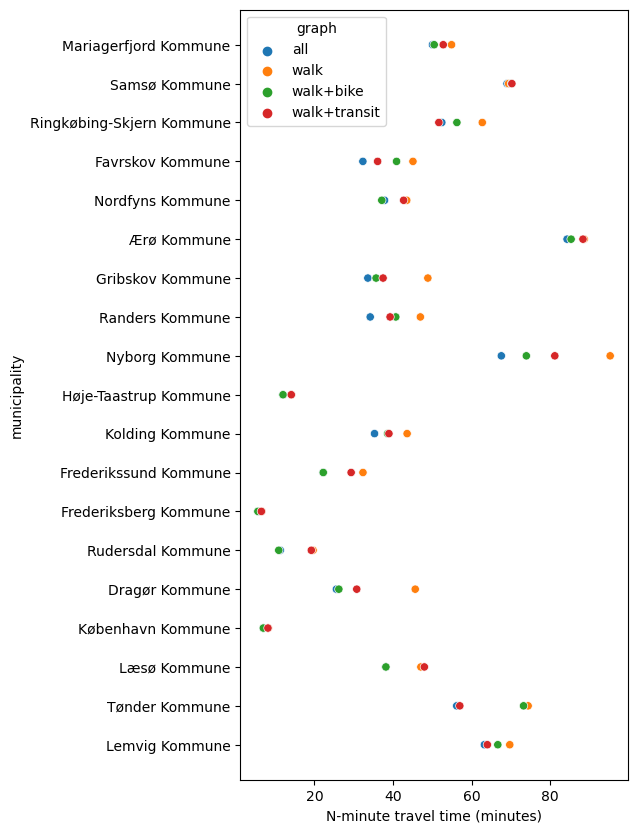

In [46]:
# plot the results as a scatter with each municipality on the x, travel time on the y, and graph type as color
plt.figure(figsize=(5,10))
sns.scatterplot(data=plotting_results, x='mean_farthest_travel_time', y='municipality', hue='graph')
# rotate the x labels
#plt.xticks(rotation=45)
plt.xlabel('N-minute travel time (minutes)')

In [29]:
# the average longest amenitiy travel time for each municipality, graph type pair
test.max(axis=1).mean()

50.04775284962727

In [9]:
df = pd.DataFrame(results["_".join(municipalities[0])]['all']).reset_index()
df.columns=['h3_index']+category_set
df = df.melt(id_vars='h3_index', var_name='category', value_name='travel_time')

In [10]:
df

,h3_index,category,travel_time
0,631051925623778303,pharmacy,66.937064
1,631051926203633151,pharmacy,43.734517
2,631051558530428415,pharmacy,10.548700
3,631051931304529407,pharmacy,12.105677
4,631051931308198399,pharmacy,15.020006
...,...,...,...
4165,631051563020466175,school,41.984781
4166,631051563120088063,school,36.044032
4167,631051931678491135,school,26.789414
4168,631051559756995583,school,27.461951


In [13]:
mins = results['_'.join(municipalities[0])]['all']

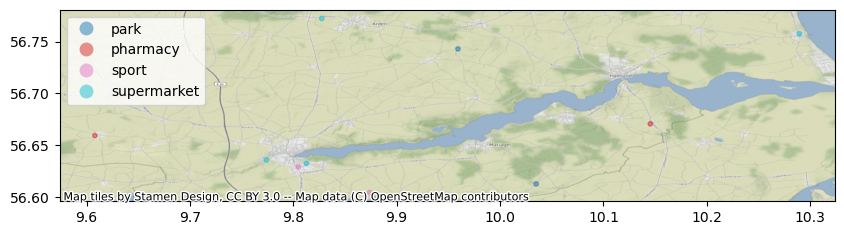

In [11]:
sample_df = df.sample(10) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
# geopandas.points_from_xy(x, y, z=None, crs=None)
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', categorical=True, legend=True, markersize=10, alpha=0.5)

# denmark
#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

# middle east
#plt.ylim(12.391681,12.737388)
#plt.xlim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_35605/2157684182.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])


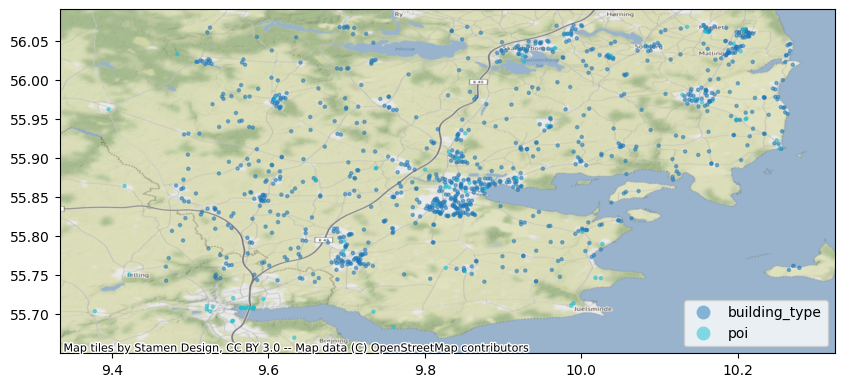

In [9]:
h3_df['hex_type'] = 'poi'
origins = pd.read_csv(h3_csv)
origins = origins[origins['residential_bool']==1]
origins['hex_type'] = 'building_type'
combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])

sample_df = combined.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='hex_type', categorical=True, legend=True, markersize=5, alpha=0.5)

#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

In [47]:
category_travel_time_means={}
category_travel_time_means[c] = np.nanmean(list(mins[c].values()))
category_travel_time_means

{'pharmacy': 7.524662246904987,
 'supermarket': 4.41982164818431,
 'sport': 7.792609982534439,
 'school': 4.3095285151723655}

NameError: name 'mins' is not defined

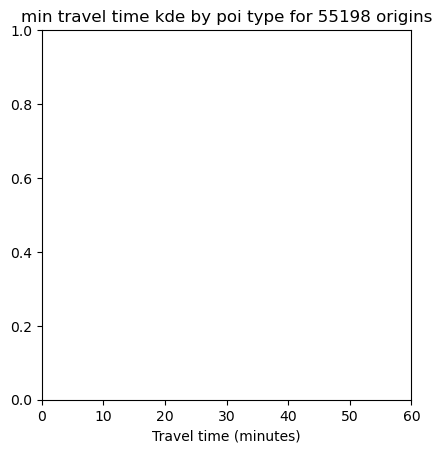

In [12]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Travel time (minutes)")
ax.set_title(f"min travel time kde by poi type for {len(origins)} origins")
ax.set_box_aspect(1)
ax.set_xlim(0, 60)
#ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    sns.kdeplot(list(mins[c].values()), color=colors[i], fill=True, alpha=0.5, ax=ax)

# Add a legend
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/kde_pois_{len(origins)}_origins.png', dpi=300)

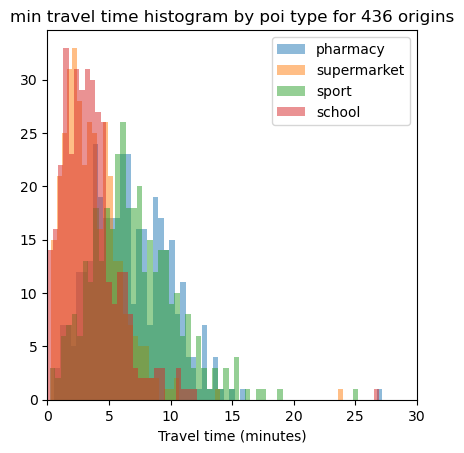

In [65]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Travel time (minutes)")
ax.set_title(f"min travel time histogram by poi type for {len(origins)} origins")
ax.set_box_aspect(1)
ax.set_xlim(0, 30)
#ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    plt.hist(list(mins[c].values()), alpha=0.5, bins=300)

# Add a legend
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/hist_pois{len(origins)}_origins.png', dpi=300)

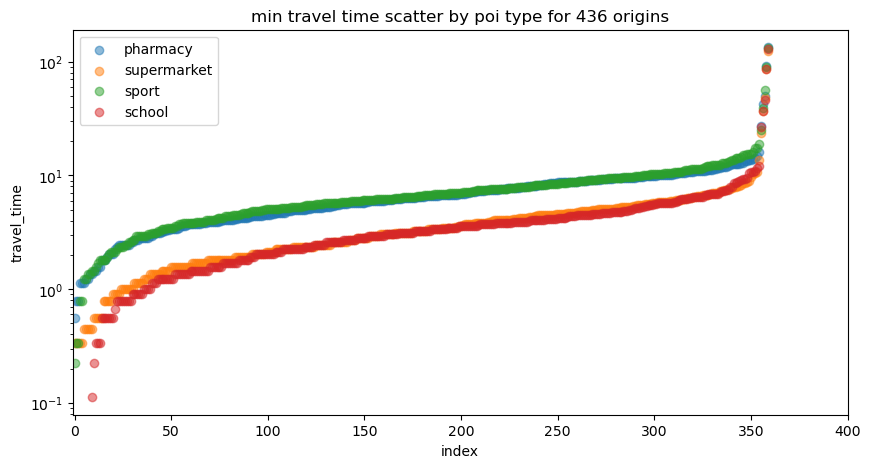

In [63]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(-1, 400)
ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), np.sort(np.array(mins[c].values(), dtype=np.float64)), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

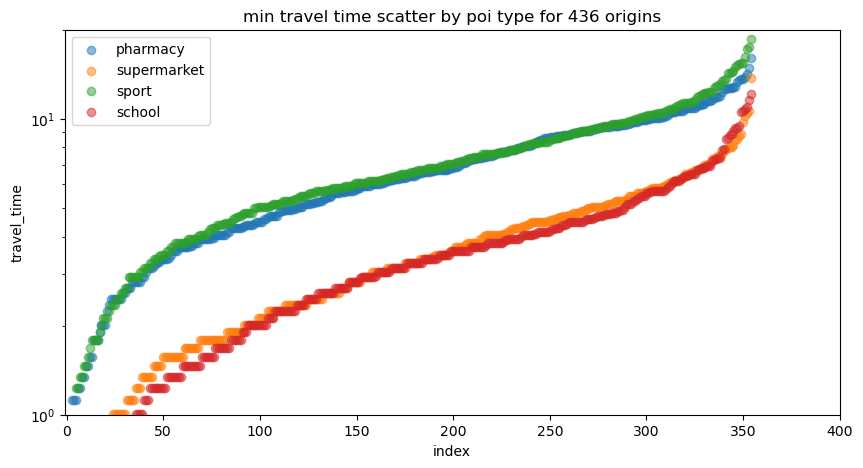

In [67]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(-1, 400)
ax.set_ylim(1, 20)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), sorted(list(mins[c].values())), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

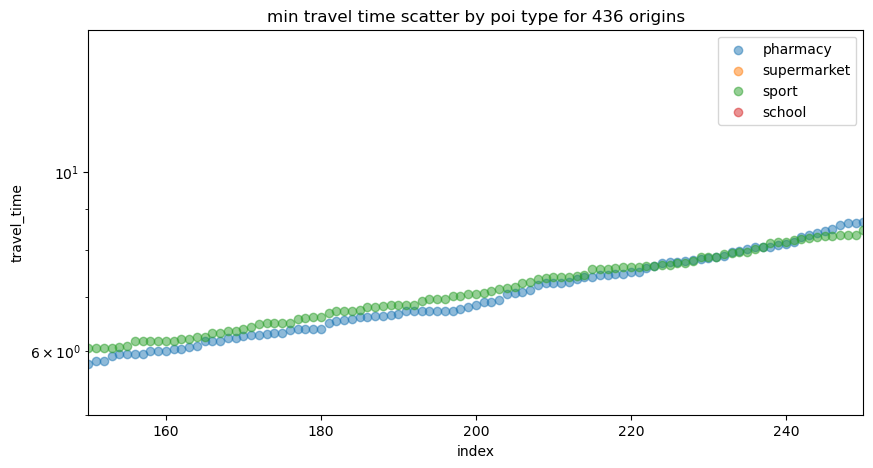

In [66]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(150, 250)
ax.set_ylim(5, 15)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), np.sort(np.array(mins[c].values(), dtype=np.float64)), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

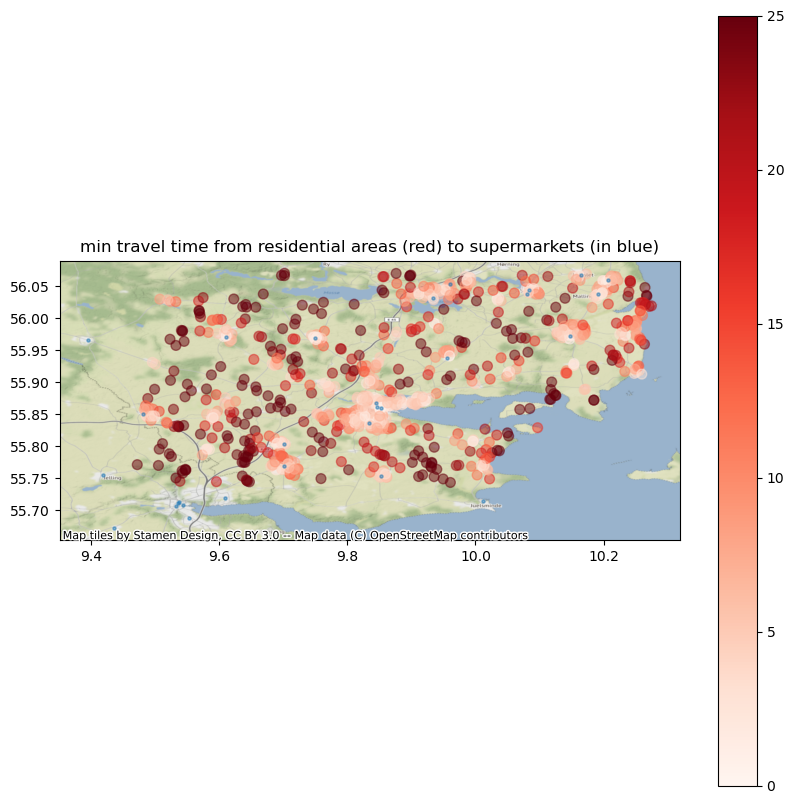

In [16]:
# plot travel time on top of poi points
plot_df = pd.DataFrame([(p,k,v) for p in mins.keys() for k,v in mins[p].items()],
                        columns = ['poi_type','h3_index','mean_dist'])
plot_df = plot_df[plot_df['poi_type']=='supermarket']
plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='mean_dist', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
            vmin=0, vmax=25)

#plot poi points
poi_df = h3_df[h3_df['category']=='pharmacy'].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("min travel time from residential areas (red) to supermarkets (in blue)")
cx.add_basemap(ax = ax, crs="EPSG:4326")

#plt.savefig('figures/supermarkets_1000.png', dpi=300)

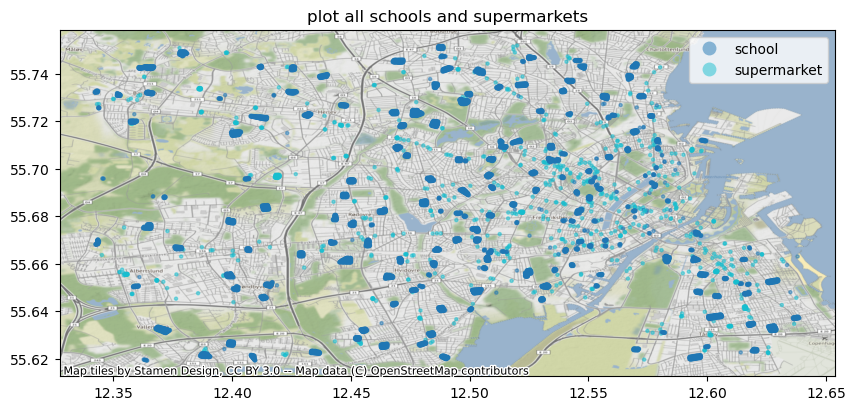

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

#plot poi points
poi_df = h3_df[h3_df['category'].isin(['school','supermarket'])].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', markersize=5, alpha=0.5, legend=True)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("plot all schools and supermarkets")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/supermarkets_and_schools.png', dpi=300)

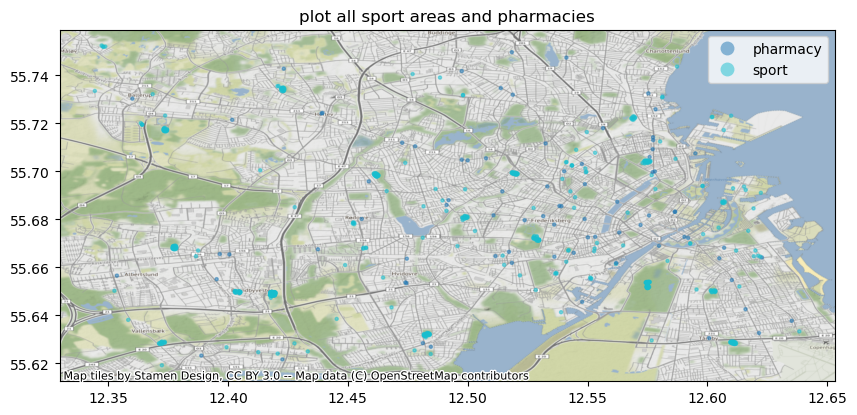

In [71]:
fig, ax = plt.subplots(figsize=(10,10))

#plot poi points
poi_df = h3_df[h3_df['category'].isin(['pharmacy','sport'])].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', markersize=5, alpha=0.5, legend=True)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("plot all sport areas and pharmacies")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/sport_and_pharmacy.png', dpi=300)

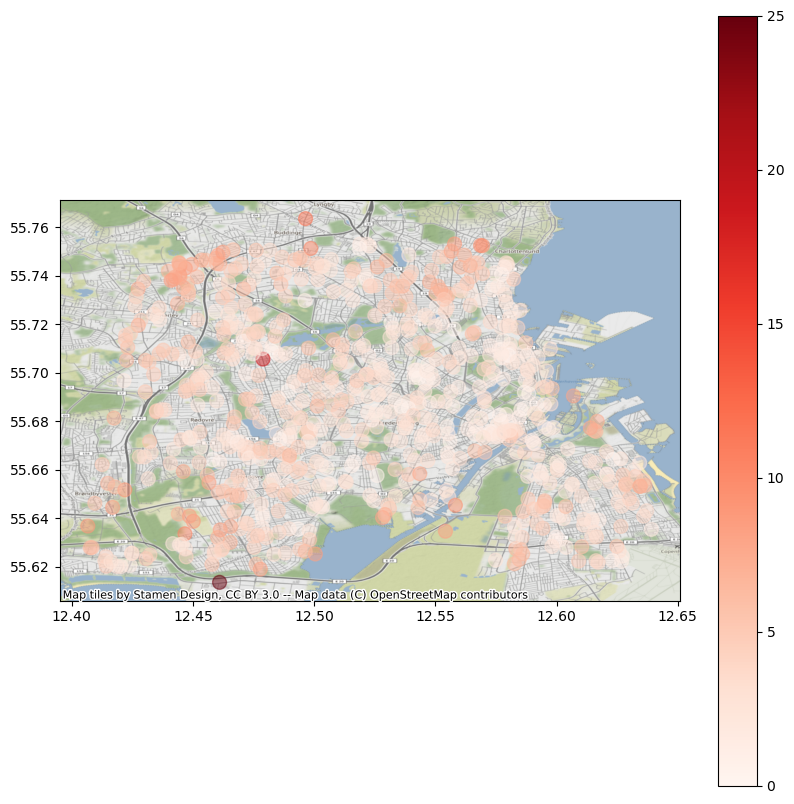

In [18]:
plot_df = pd.DataFrame([(k,v) for k,v in mins.items()], columns = ['h3_index','mean_dist'])
plot_hex_df(plot_df, markersize=100, color_column='mean_dist')